In [ ]:
# Perform various analyses on datasets and model outputs

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
from scipy.spatial import distance
from scipy.special import softmax
import matplotlib.pyplot as plt
import csv
# import multiprocessing as mp
# pool = mp.Pool(mp.cpu_count())

from utils import *

pd.options.mode.chained_assignment = None

# TF-IDF
def fil_sent(sent):
  """
  Filter stopwords
  """

  filtered_sentence = ' '.join([w for w in sent.split() if not w in stop_words])
  return filtered_sentence

def process_tfidf(sent):
  """
  Apply stemming
  """

  sent = str(sent)
  return fil_sent(' '.join([ps.stem(str(x).lower()) for x in word_tokenize(sent)]))

stop_words = set(stopwords.words('english'))
ps = PorterStemmer() 
vectorizer = TfidfVectorizer()

In [18]:
file1 = '21a'
file2 = '21b'

num_authors = 50
token_len = 256

df1 = pd.read_csv(f'{file1}.csv')
df2 = pd.read_csv(f'{file2}.csv')
df1 = df1.rename(columns={'is_correct': 'is_correct_1'})
df2 = df2.rename(columns={'is_correct': 'is_correct_2'})
df1 = df1.rename(columns={'actual_pred': 'actual_pred_1'})
df2 = df2.rename(columns={'actual_pred': 'actual_pred_2'})
df1 = df1.drop(columns=['content'])
df2 = df2.drop(columns=['author'])

df1 = df1.set_index('index')
df2 = df2.set_index('index')

df = pd.concat([df1, df2], axis=1)

print(len(df))
print(len(df[(df['is_correct_1'] == 1) & (df['is_correct_2'] == 1)]))
print(len(df[(df['is_correct_1'] == 0) & (df['is_correct_2'] == 1)]))
print(len(df[(df['is_correct_1'] == 1) & (df['is_correct_2'] == 0)]))
print(len(df[(df['is_correct_1'] == 0) & (df['is_correct_2'] == 0)]))

7296
4265
724
452
1855


In [70]:
df.to_csv(f'{file1}_{file2}.csv')

In [19]:
df = pd.read_csv(f'{file1}_{file2}.csv')

In [153]:
df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9",  "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]] = df['content'].apply(lambda x: extract_style(x))

In [4]:
def analyse_against_token_len(df):
    df_shorter = df[df['length'] < token_len]
    #print(f'Samples under token length: {len(df_shorter)} ({"{:.2f}".format(len(df_shorter) * 100 / len(df))}%)')
    return len(df_shorter)
    

In [5]:
def analyse_tf_idf(df):
    df['content_tfidf'] = df['content'].apply(lambda x: process(x))
    x = vectorizer.fit_transform(df['content_tfidf'])
    print(x)

In [62]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['content'])
lda = LatentDirichletAllocation(n_components=20, random_state=0, max_iter=500)
topic_dist = lda.fit_transform(x)

# bit scuffed- store prob. dist. as csv string
topic_dist = list(map(lambda x: map(lambda y: str(y), x), topic_dist))
topic_dist = list(map(lambda x: ','.join(x), topic_dist))
df['topic_dist'] = topic_dist

In [4]:
print(df['topic_dist'])
def analyse_topic(df):
#     vectorizer = CountVectorizer()
#     x = vectorizer.fit_transform(df['content'])
#     lda = LatentDirichletAllocation(n_components=10, random_state=0, max_iter=10)
#     lda.fit(x)
    x = vectorizer.fit_transform(df['content'])
    dist = np.array(lda.transform(x))
    #print(dist)
    
    # take mean of distribution of each sample
    return np.mean(dist, axis=0)

def analyse_author_topic(df, author):
    return analyse_topic(df[(df['author'] == author)])

def analyse_split_topic(df):
    dist = analyse_topic(df)
    print(f'Variance of topic distribution: {"{:.4f}".format(np.var(dist))}')

0       7.987220495210293e-05,7.987220455724644e-05,7....
1       0.5874999992964991,0.004166666666707949,0.0041...
2       0.0008333333638912788,0.0008333333333387802,0....
3       0.002941176488801516,0.002941176470603999,0.00...
4       0.009674855266294847,7.102272744846018e-05,7.1...
                              ...                        
7291    0.0016666667327107333,0.001666666666668327,0.0...
7292    0.000806451627481693,0.0008064516129079517,0.0...
7293    0.003333333370376489,0.0033333333340039638,0.0...
7294    0.0018518518618104486,0.0018518518583331095,0....
7295    0.1395267677912408,0.0018518518519173705,0.001...
Name: topic_dist, Length: 7296, dtype: object


[0.0, 0.19442557700096696, 0.17573309245352184, 0.17995627534252792, 0.16600553031632703, 0.13491335236547536, 0.288830976289208, 0.10057417662559472, 0.25849417139331526, 0.2160714512786502, 0.23466282081436984, 0.18129110458030484, 0.20109009630981134, 0.1520547555405233, 0.21693640128846262, 0.2013209216811518, 0.20303736156325516, 0.23536074536763518, 0.20540813235640443, 0.1963110219069031, 0.15955551665538836, 0.2352595295053577, 0.41817650557303854, 0.1946698776383773, 0.20749613637000286, 0.26691283885673117, 0.2649169908100779, 0.2592523645718112, 0.2896161864959799, 0.2896503210958491, 0.2589631252663395, 0.29545105321087106, 0.26568720452300937, 0.20869512150527325, 0.20863310867201687, 0.1576009244819482, 0.22228328718590612, 0.17559836989789437, 0.2399436436349539, 0.26349043373501224, 0.1725710203923748, 0.2746888290703051, 0.2570232832642415, 0.19863917858223165, 0.2608869755956166, 0.2719336633893559, 0.23698813090368576, 0.2490835750385786, 0.23915844959121524, 0.20166

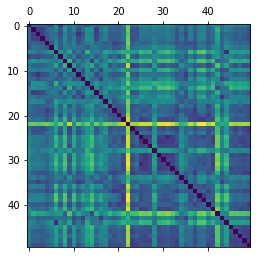

In [5]:
# df = pd.read_csv(f'{file1}_{file2}.csv')
# print(df)
# df['author'] = df['Target']
# auths = df['author'].unique().tolist()
# df['author'] = pd.Series(map(lambda x: auths.index(x), df['From'].tolist()))

def convert_str_to_list(string):
    list_str = string.split(',')
    float_str = list(map(lambda x: float(x), list_str))
    return float_str

def analyse_dataset_topic(df):
#     distributions = [analyse_author_topic(df, author) for author in range(num_authors)]

    distributions = [df[df['author'] == author]['topic_dist'].tolist() for author in range(num_authors)]
    distributions = list(map(lambda x: list(map(lambda y: convert_str_to_list(y), x)), distributions))
    distributions = list(map(lambda x: np.mean(x, axis=0), distributions))
    jsd = [[distance.jensenshannon(distributions[i], distributions[j]) for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
    plt.matshow(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     for j in mean_jsd:
#         print(j)
    
analyse_dataset_topic(df)

def analyse_dataset_corpus_topic(df):
#     distributions = [analyse_author_topic(df, author) for author in range(num_authors)]

    distributions = df[(df['is_correct_1'] == 0) & (df['is_correct_2'] == 1)]['topic_dist'].tolist()
    distributions = list(map(lambda y: convert_str_to_list(y), distributions))
    distributions = np.mean(distributions, axis=0)
    plt.plot(distributions)
    
    
    distributions = df[(df['is_correct_1'] == 1) & (df['is_correct_2'] == 0)]['topic_dist'].tolist()
    distributions = list(map(lambda y: convert_str_to_list(y), distributions))
    distributions = np.mean(distributions, axis=0)
    plt.plot(distributions)
    plt.show()
#     jsd = [[distance.jensenshannon(distributions[i], distributions[j]) for j in range(num_authors)] for i in range(num_authors)]
# #     for j in jsd:
# #         print(j)
#     plt.matshow(jsd)
#     mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd)

# analyse_dataset_corpus_topic(df)

In [6]:
def tokenize(text):  # tokenize the text
    tokens = nltk.word_tokenize(text)
    return tokens

# --- Lexical Features --- #

# Lexical feature (word level)
def average_total_words(x_train):
    sum_wrd = 0
    for text_doc in x_train:
        total_wrd = len(word_tokenize(text_doc))
        sum_wrd += total_wrd
    return sum_wrd/len(x_train)

def total_words(text_doc, x_train):
    avg = average_total_words(x_train)
    total_wrd = len(word_tokenize(text_doc))
    return total_wrd/avg

def average_word_length(text_doc):
    word_list = text_doc.split()
    average = sum(len(word) for word in word_list)/len(word_list)
    return average

def total_short_words(text_doc):
    word_list = text_doc.split()
    count_short_word = 0
    for word in word_list:
        if len(word) < 4:
            count_short_word += 1
    return count_short_word/len(word_list)

# Lexical feature (character level)

def avg_total_char(x_train):
    sum_chr = 0
    for text_doc in x_train:
        total_chr = len(text_doc)
        sum_chr += total_chr
    return sum_chr/len(x_train)

def total_char(text_doc, x_train):
    avg = avg_total_char(x_train)
    return len(text_doc)/avg

def total_digit(text_doc):
    return sum(c.isdigit() for c in text_doc)/len(text_doc)

def total_uppercase(text_doc):
    return sum(1 for c in text_doc if c.isupper())/len(text_doc)


# Lexical feature (letter frequency)

def count_letter_freq(text_doc):  # per document (vector with length 26)
    text_doc = ''.join([i for i in text_doc if i.isalpha()])
    letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's'
              , 't', 'u', 'v', 'w', 'x', 'y', 'z']
    count = {}
    for s in text_doc:
      if s in count.keys():
        count[s] += 1
      else:
        count[s] = 1
    count_list = {}
    for d in letter:
        if d in count.keys():
            count_list[d] = count[d]
        else:
            count_list[d] = 0
    if len(text_doc) == 0:
        return [0 for i in range(len(list(count_list.values())))]
    return np.array(list(count_list.values()))/len(text_doc)
# Lexical feature (digit frequency)


def count_digit_freq(text_doc):   # per document (vector with length 10)
    text_doc = ''.join([i for i in text_doc if i.isdigit()])
    digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    count = {}
    for s in text_doc:
      if s in count.keys():
        count[s] += 1
      else:
        count[s] = 1
    count_list = {}
    for d in digits:
        if d in count.keys():
            count_list[d] = count[d]
        else:
            count_list[d] = 0
    if len(text_doc) == 0:
        return [0 for i in range(len(list(count_list.values())))]
    return np.array(list(count_list.values()))/len(text_doc)


def average_sentence_length(text_doc):
    sent_list = sent_tokenize(text_doc, language='english')
    average = sum(len(sent) for sent in sent_list)/len(sent_list)
    return average


# Lexical Feature (vocabulary richness)
def hapax_legomena_ratio(text):  # # per document only a float value
    word_list = text.split()
    fdist = nltk.FreqDist(word for word in word_list)
    fdist_hapax = nltk.FreqDist.hapaxes(fdist)
    return float(len(fdist_hapax)/len(word_list))


def dislegomena_ratio(text):  # per document only a float value
    word_list = text.split()
    vocabulary_size = len(set(word_list))
    freqs = Counter(nltk.probability.FreqDist(word_list).values())
    VN = lambda i:freqs[i]
    return float(VN(2)*1./vocabulary_size)

def find_fn_word_freq(text):  # per document (vector with length 150)
    words = text.split()
    
    style_features = []
    with open('function_words.txt') as f:
        style_features = list(map(lambda x: x.strip('\n'), f.readlines()))
        
    punctuations = ['\'', ':', ',', '_', '!', '?', ';', ".", '\"', '(', ')', '-']
    
    style_features += punctuations
    
    count = {}
    for word in words:
      if word in dict.keys(count):
        count[word] += 1
      else:
        count[word] = 1
    count_list = {}
    for d in style_features:
        if d in count.keys():
            count_list[d] = count[d]
        else:
            count_list[d] = 0
    if len(words) == 0:
        return [0 for i in range(len(list(count_list.values())))]
    vec = np.array(list(count_list.values()))
    return vec/len(words)

def get_stylometric_features(x):
    stylometry_vector = []
    stylometry_vector.append(average_word_length(x))
    stylometry_vector.append(total_short_words(x))
    stylometry_vector.append(total_digit(x))
    stylometry_vector.append(total_uppercase(x))
    stylometry_vector.extend(count_letter_freq(x))
    stylometry_vector.extend(count_digit_freq(x))
    stylometry_vector.append(hapax_legomena_ratio(x))
    stylometry_vector.append(dislegomena_ratio(x))
    stylometry_vector.extend(find_fn_word_freq(x))
    return stylometry_vector

def analyse_style_features(df):
    content = df['content'].tolist()
    #print(map(lambda x: find_fn_word_freq(x), content))
    dist = np.mean(list(map(lambda x: get_stylometric_features(x), content)), axis=0)
    return dist

def analyse_author_style(df, author):
    return analyse_style_features(df[(df['author'] == author)])

0.0003000991084021698
0.0002762117234280503
0.0004733721515416467
0.00033762647207977945
0.0005531531390454014
0.0005181412541790675
0.0005434163025971839
0.00031235215300607467
0.00035134665580450976
0.0004555015278941199
0.00029894622968105854
0.0003245352141471836
0.0003973264888132877
0.0009752159345177414
0.0004086792654053917
0.0003090863277531142
0.0003455576286349071
0.0012471708863133779
0.00032333217752459785
0.0003788033245187061
0.00044259657780103544
0.0005658602793611589
0.0003815868423192059
0.0003572422514150575
0.0005470189197583463
0.00026065370018627074
0.00041622416589750746
0.0006502005388016219
0.00034088541463277
0.000290421208011018
0.0002688610273699155
0.0003775882268260244
0.0005549248801499918
0.0002819251442945481
0.0005773377552927527
0.000258739112655435
0.0007289998336936865
0.00040288049914125154
0.0005242584860865951
0.000433651430389419
0.0002966111930130677
0.0003089528704617406
0.0007792473997565863
0.00028901235697782914
0.0004755690493835796
0.000

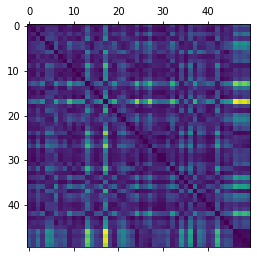

In [7]:
def analyse_dataset_style(df):
    distributions = [analyse_author_style(df, author) for author in range(num_authors)]
    #print(distributions)
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
    plt.matshow(jsd)
#     plt.matshow(jsd, cmap='gray', vmin=0, vmax=255)
    mean_jsd = np.mean(jsd, axis=0)
    for j in mean_jsd:
        print(j)

analyse_dataset_style(df)

In [20]:
#max_features = 100 * int(num_authors / 10)

vec_bigram = CountVectorizer(analyzer="char", ngram_range=(2, 2), max_df=0.95, min_df=2)
vec_bigram.fit_transform(df['content'].tolist())
vocab_bigram = vec_bigram.vocabulary_
vectorizer_bigram = CountVectorizer(analyzer="char", ngram_range=(2, 2), vocabulary=vocab_bigram, max_features=int(0.1*len(vocab_bigram)))
vectorizer_bigram.fit_transform(df['content'].tolist())

vec_trigram = CountVectorizer(analyzer="char", ngram_range=(3, 3), max_df=0.95, min_df=2)
vec_trigram.fit_transform(df['content'].tolist())
vocab_trigram = vec_trigram.vocabulary_
vectorizer_trigram = CountVectorizer(analyzer="char", ngram_range=(3, 3), vocabulary=vocab_trigram, max_features=int(0.1*len(vocab_trigram)))
vectorizer_trigram.fit_transform(df['content'].tolist())

vec_word_unigram = CountVectorizer(analyzer="word", ngram_range=(1, 1), max_df=0.95, min_df=2, stop_words="english")
vec_word_unigram.fit_transform(df['content'].tolist())
vocab_word_unigram = vec_word_unigram.vocabulary_
vectorizer_word_unigram = CountVectorizer(analyzer="word", ngram_range=(1, 1), vocabulary=vocab_word_unigram, max_features=int(0.1*len(vocab_word_unigram)))
vectorizer_word_unigram.fit_transform(df['content'].tolist())

vec_word_bigram = CountVectorizer(analyzer="word", ngram_range=(2, 2), max_df=0.95, min_df=2, stop_words="english")
vec_word_bigram.fit_transform(df['content'].tolist())
vocab_word_bigram = vec_word_bigram.vocabulary_
vectorizer_word_bigram = CountVectorizer(analyzer="word", ngram_range=(2, 2), vocabulary=vocab_word_bigram, max_features=int(0.1*len(vocab_word_bigram)))
vectorizer_word_bigram.fit_transform(df['content'].tolist())

vec_word_trigram = CountVectorizer(analyzer="word", ngram_range=(3, 3), max_df=0.95, min_df=2, stop_words="english")
vec_word_trigram.fit_transform(df['content'].tolist())
vocab_word_trigram = vec_word_trigram.vocabulary_
vectorizer_word_trigram = CountVectorizer(analyzer="word", ngram_range=(3, 3), vocabulary=vocab_word_trigram, max_features=int(0.1*len(vocab_word_trigram)))
vectorizer_word_trigram.fit_transform(df['content'].tolist())

def char_bigrams(text):
    feature_bigrams = vectorizer_bigram.transform(text)
    return feature_bigrams.toarray()

def char_trigrams(text):
    feature_trigrams = vectorizer_trigram.transform(text)
    return feature_trigrams.toarray()

def word_unigrams(text):
    feature_wunigrams = vectorizer_word_unigram.transform(text)
    return feature_wunigrams.toarray()

def word_bigrams(text):
    feature_wbigrams = vectorizer_word_bigram.transform(text)
    return feature_wbigrams.toarray()

def word_trigrams(text):
    feature_wtrigrams = vectorizer_word_trigram.transform(text)
    return feature_wtrigrams.toarray()


def analyse_bigrams(df):
    content = df['content'].tolist()
    dist = np.mean(char_bigrams(content), axis=0)
    return dist

def analyse_author_bigrams(df, author):
    return analyse_bigrams(df[(df['author'] == author)])

def analyse_trigrams(df):
    content = df['content'].tolist()
    dist = np.mean(char_trigrams(content), axis=0)
    return dist

def analyse_author_trigrams(df, author):
    return analyse_trigrams(df[(df['author'] == author)])

def analyse_word_unigrams(df):
    content = df['content'].tolist()
    dist = np.mean(word_unigrams(content), axis=0)
    return dist

def analyse_author_word_unigrams(df, author):
    return analyse_word_unigrams(df[(df['author'] == author)])

def analyse_word_bigrams(df):
    content = df['content'].tolist()
    dist = np.mean(word_bigrams(content), axis=0)
    return dist

def analyse_author_word_bigrams(df, author):
    return analyse_word_bigrams(df[(df['author'] == author)])

def analyse_word_trigrams(df):
    content = df['content'].tolist()
    dist = np.mean(word_trigrams(content), axis=0)
    return dist

def analyse_author_word_trigrams(df, author):
    return analyse_word_trigrams(df[(df['author'] == author)])

0.029292854358356067

0.08429519568741287

0.45270425653855956

0.8951719635389167

0.9546872524271974

0.00046270835561894563

0.2212487546091277

0.14004267285605215
0.7780821338976516
0.15910079991405351
0.39778788876545657


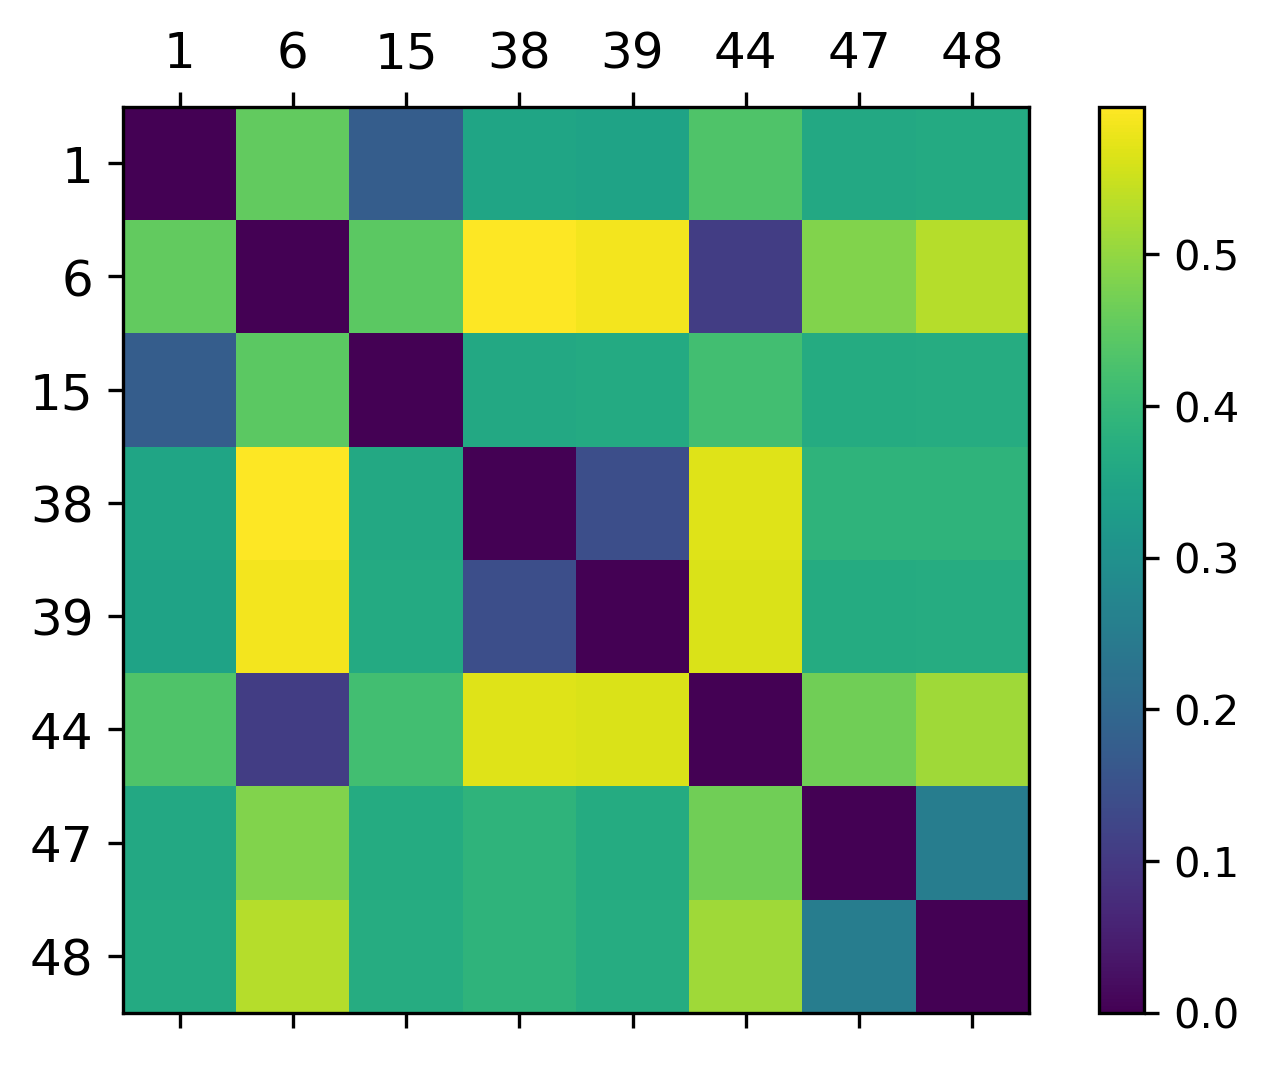

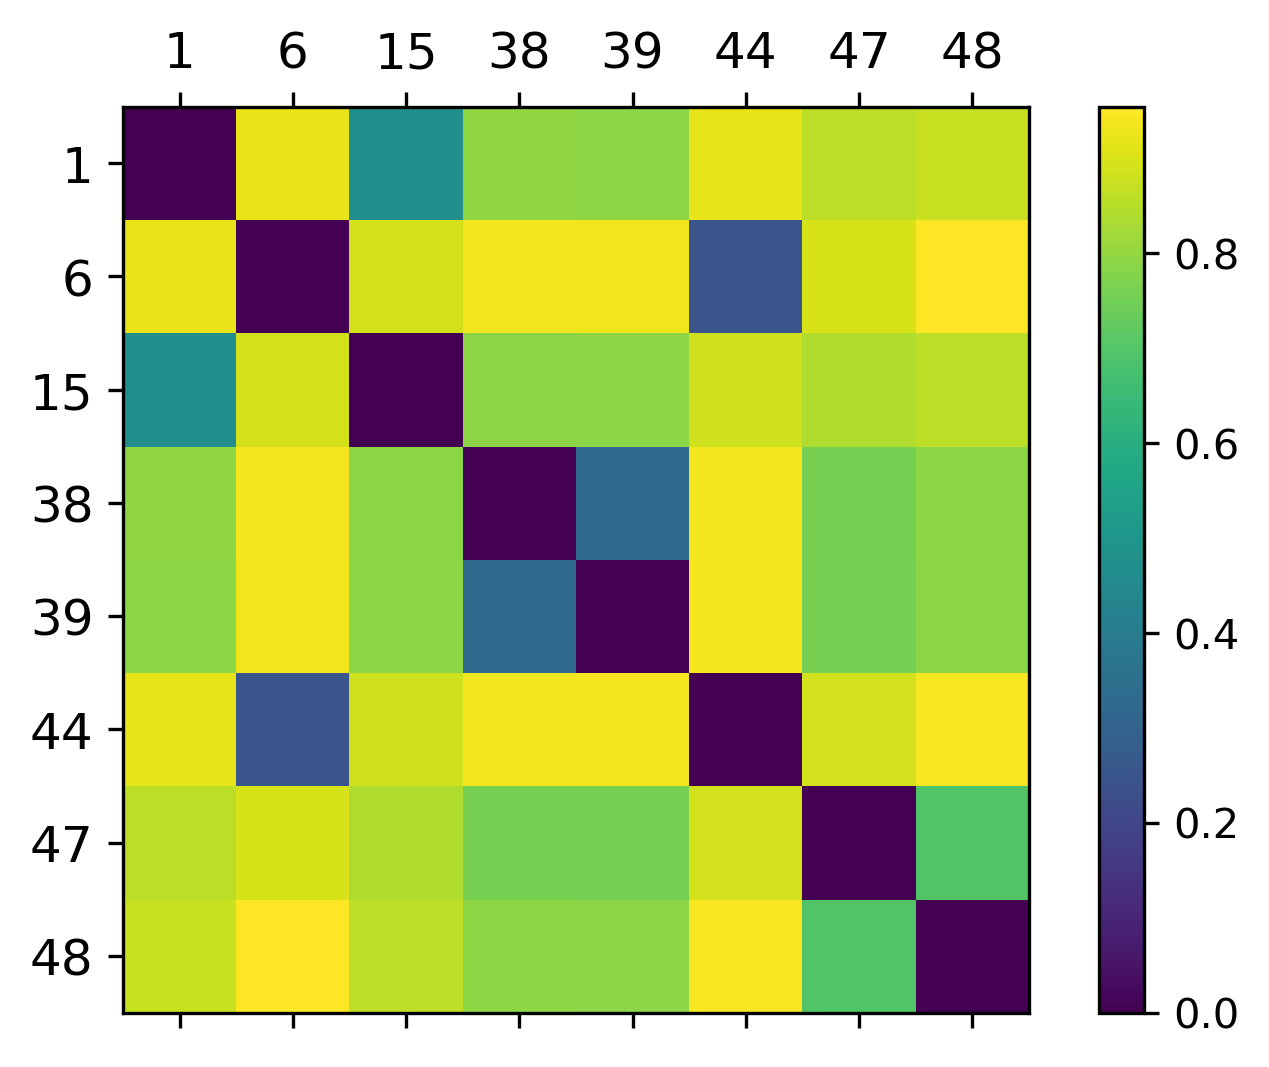

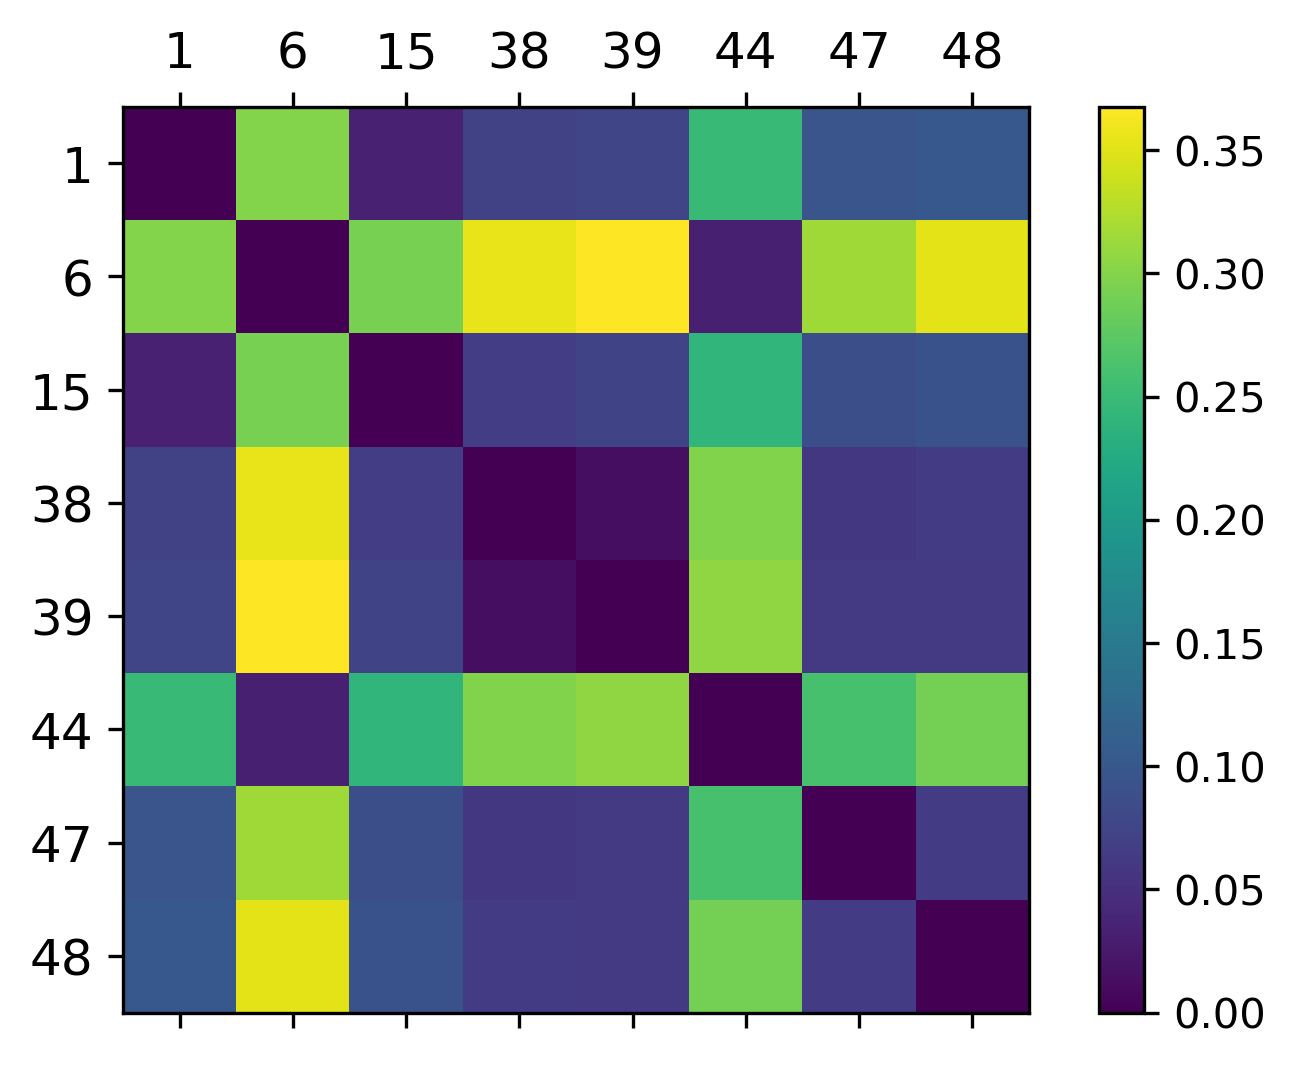

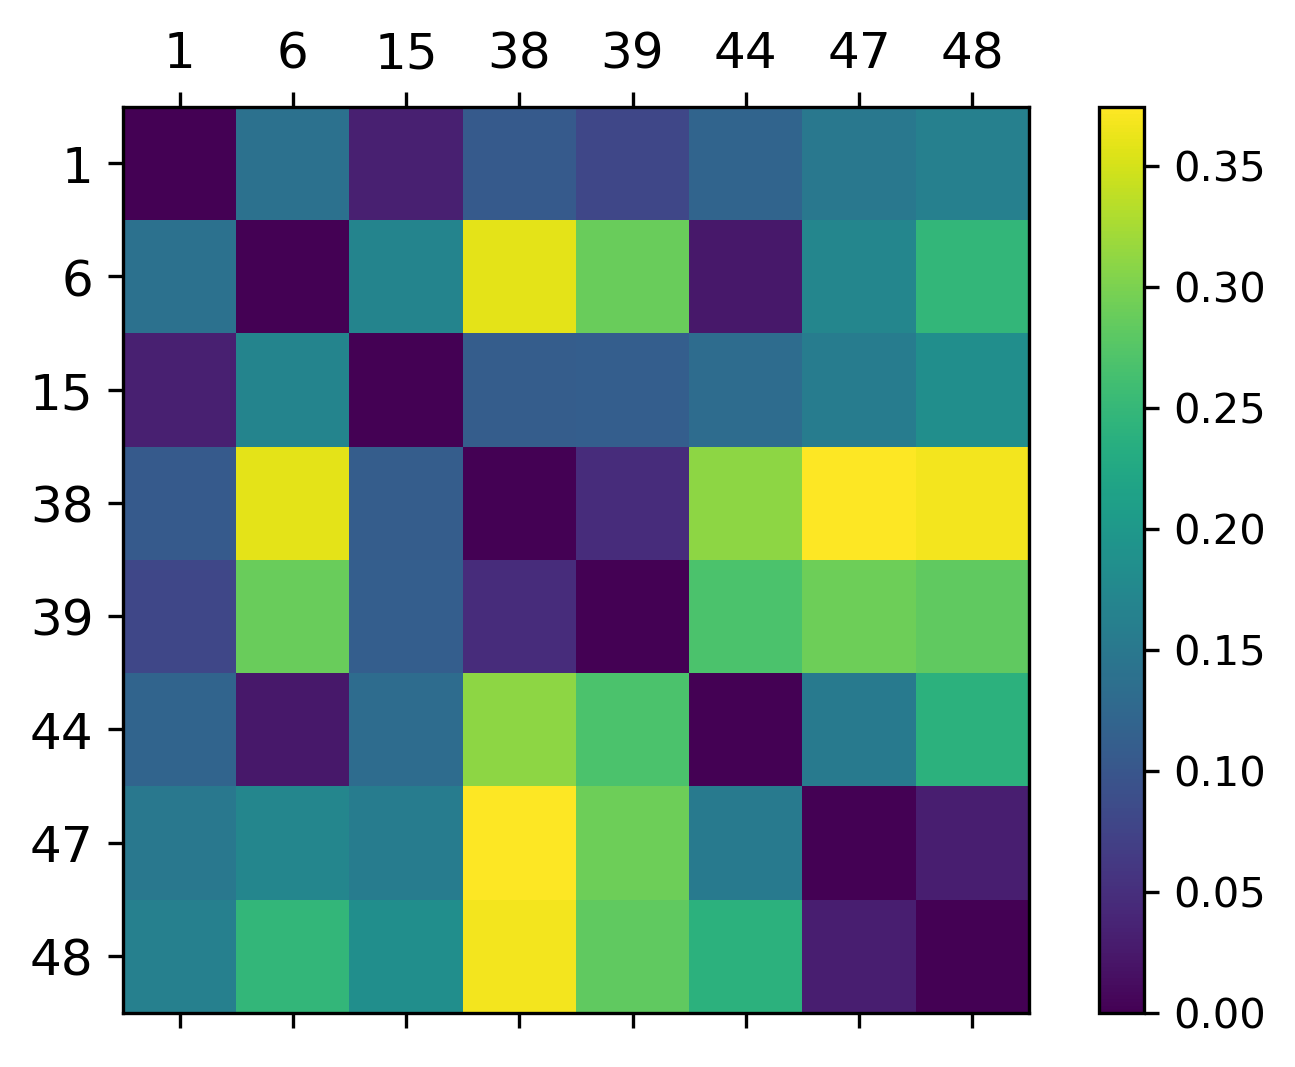

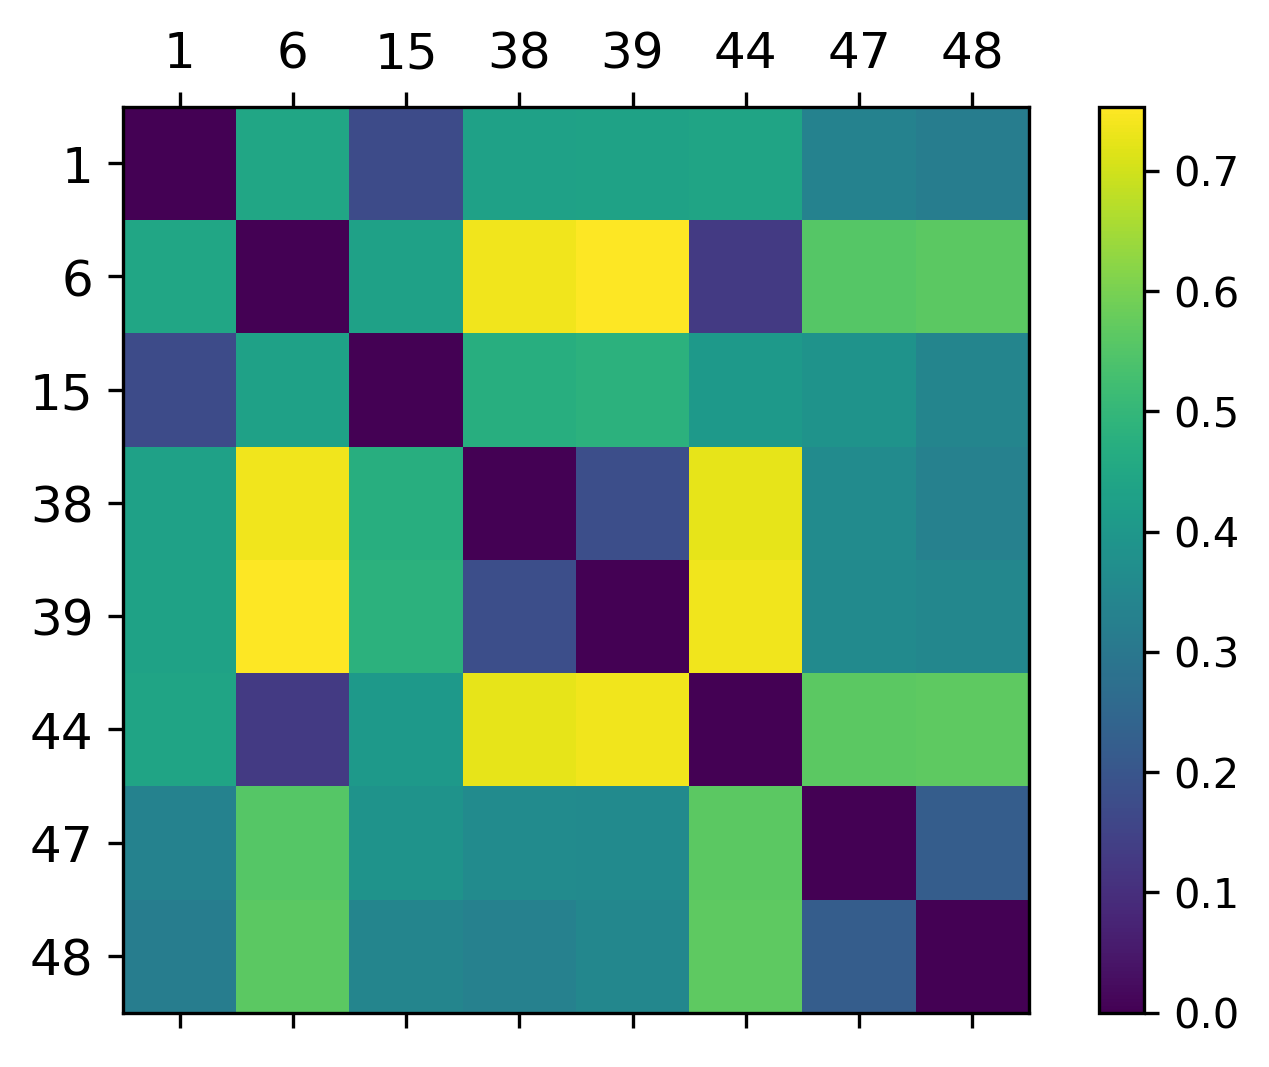

In [21]:
auth1 = 30
auth2 = 29
# num_authors = 50
# df = pd.read_csv(f'{file1}_{file2}.csv')

combined_feats = []
style_feats = []
topic_feats = []
content_feats = []
hybrid_feats = []

def analyse_dataset_bigrams(df):
    distributions = [analyse_author_bigrams(df, author) for author in range(num_authors)]
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
#     print(jsd[auth1][auth2])
    hybrid_feats.append(jsd)
#     plt.matshow(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)

analyse_dataset_bigrams(df)
print('')

def analyse_dataset_trigrams(df):
    distributions = [analyse_author_trigrams(df, author) for author in range(num_authors)]
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
#     print(jsd[auth1][auth2])
    hybrid_feats.append(jsd)
    #plt.matshow(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)
    
analyse_dataset_trigrams(df)
print('')

def analyse_dataset_word_unigrams(df):
    distributions = [analyse_author_word_unigrams(df, author) for author in range(num_authors)]
#     jsd = [[distance.jensenshannon(softmax(distributions[i]), softmax(distributions[j])) for j in range(num_authors)] for i in range(num_authors)]
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
#     print(jsd[auth1][auth2])
    content_feats.append(jsd)
#     plt.matshow(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)

analyse_dataset_word_unigrams(df)
print('')

def analyse_dataset_word_bigrams(df):
    distributions = [analyse_author_word_bigrams(df, author) for author in range(num_authors)]
#     jsd = [[distance.jensenshannon(softmax(distributions[i]), softmax(distributions[j])) for j in range(num_authors)] for i in range(num_authors)]
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
#     print(jsd[auth1][auth2])
    content_feats.append(jsd)
#     plt.matshow(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)

analyse_dataset_word_bigrams(df)
print('')

def analyse_dataset_word_trigrams(df):
    distributions = [analyse_author_word_trigrams(df, author) for author in range(num_authors)]
#     jsd = [[distance.jensenshannon(softmax(distributions[i]), softmax(distributions[j])) for j in range(num_authors)] for i in range(num_authors)]
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     for j in jsd:
#         print(j)
#     print(jsd[auth1][auth2])
    content_feats.append(jsd)
#     plt.matshow(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)

analyse_dataset_word_trigrams(df)
print('')

def analyse_pairwise_style(df):
    distributions = [analyse_author_style(df, author) for author in range(num_authors)]
    jsd = [[1 - cosine_similarity([distributions[i]], [distributions[j]])[0][0] for j in range(num_authors)] for i in range(num_authors)]
#     print(jsd[auth1][auth2])
    style_feats.append(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)
    
analyse_pairwise_style(df)
print('')

def analyse_pairwise_topic(df):
#     distributions = [analyse_author_topic(df, author) for author in range(num_authors)]

    distributions = [df[df['author'] == author]['topic_dist'].tolist() for author in range(num_authors)]
    distributions = list(map(lambda x: list(map(lambda y: convert_str_to_list(y), x)), distributions))
    distributions = list(map(lambda x: np.mean(x, axis=0), distributions))
    jsd = [[distance.jensenshannon(distributions[i], distributions[j]) for j in range(num_authors)] for i in range(num_authors)]
#     print(jsd[auth1][auth2])
    topic_feats.append(jsd)
    mean_jsd = np.mean(jsd, axis=0)
#     print(mean_jsd[auth1])
#     print(mean_jsd[auth2])
#     print(np.std(mean_jsd))
    print(np.mean(jsd))
#     for j in mean_jsd:
#         print(j)


analyse_pairwise_topic(df)
print('')

def normalise(arr):
    max_value = np.amax(arr)
#     print(max_value)
    #print(arr)
    return np.array(arr) * (1 / max_value)

content_feats = np.mean(list(map(lambda x: normalise(x), content_feats)), axis=0)
topic_feats = np.mean(list(map(lambda x: normalise(x), topic_feats)), axis=0)
style_feats = np.mean(list(map(lambda x: normalise(x), style_feats)), axis=0)
hybrid_feats = np.mean(list(map(lambda x: normalise(x), hybrid_feats)), axis=0)
content_mean = np.mean(content_feats)
topic_mean = np.mean(topic_feats)
style_mean = np.mean(style_feats)
hybrid_mean = np.mean(hybrid_feats)

print(hybrid_mean)
print(content_mean)
print(style_mean)
print(topic_mean)

combined_feats = np.mean([content_feats, topic_feats, style_feats, hybrid_feats], axis=0)

def plot_author_graph(data, alpha):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest')
    fig.colorbar(cax)

    xaxis = np.arange(len(alpha))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(alpha, fontsize=12)
    ax.set_yticklabels(alpha, fontsize=12)
#     ax.set_xlabel( '$Author$' + ' ' + '$A_{i}$', fontsize=16, labelpad=12)
#     ax.set_ylabel('$Author$' + ' ' + '$A_{j}$', fontsize=16)
    ax.xaxis.set_label_position('top') 
    
    plt.show()


alpha = [1, 6, 15, 38, 39, 44, 47, 48]
# alpha = [6, 12, 26, 30, 38, 39, 43, 44]

plot_author_graph(combined_feats[np.ix_(alpha, alpha)], alpha)
plot_author_graph(content_feats[np.ix_(alpha, alpha)], alpha)
plot_author_graph(hybrid_feats[np.ix_(alpha, alpha)], alpha)
plot_author_graph(style_feats[np.ix_(alpha, alpha)], alpha)
plot_author_graph(topic_feats[np.ix_(alpha, alpha)], alpha)


In [33]:
def get_mean_pairwise_topic_divergence(df):
    distributions = [df[df['author'] == author]['topic_dist'].tolist() for author in range(num_authors)]
    distributions = list(map(lambda x: list(map(lambda y: convert_str_to_list(y), x)), distributions))
    distributions = list(map(lambda x: np.mean(x, axis=0), distributions))
    jsd = [[distance.jensenshannon(distributions[i], distributions[j]) for j in range(num_authors)] for i in range(num_authors)]
    print(np.mean(jsd))

get_mean_pairwise_topic_divergence(df)

0.2726572705975612


3780
913
694
[0.005446459741185193, 0.0, 0.0, 0.05795321083197671, 0.007637040245018708, 0.001094090591180814, 0.0, 0.0, 0.0, 0.0, 0.005446459741185192, 0.0010940905911808142, 0.0, 0.0065285537250065655, 0.1333950758725433, 0.011951020251472884, 0.005446459741185192, 0.011903033822035128, 0.028698284125249374, 0.015161312380858693, 0.00544645974118519, 0.0, 0.0, 0.0, 0.011903033822035128, 0.014036030610543336, 0.008719134228840082, 0.00436196643589193, 0.002185781860889741, 0.0, 0.0065285537250065655, 0.0021857818608897405, 0.02037743726074267, 0.0, 0.0, 0.0010940905911808142, 0.0, 0.0, 0.0, 0.007608248387356055, 0.006528553725006567, 0.014093614325868644, 0.008685543728233654, 0.008719134228840084, 0.00436196643589193, 0.001094090591180814, 0.28543767822459815, 0.03813241615271201, 0.0, 0.0032750738091267798, 0.0, 0.002185781860889741, 0.010832936445573198, 0.018417191618210368, 0.01302351694940671, 0.011951020251472884, 0.00436196643589193, 0.0, 0.026114214900026283, 0.0, 0.005446459

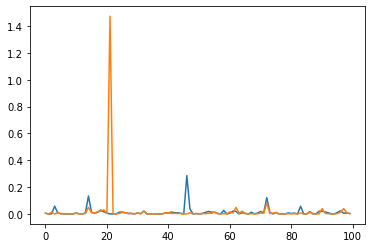

In [42]:
def get_bigram_variance(arr):
    tp = np.transpose(arr)
    return list(map(lambda x: np.var(x), tp))

def analyse_corpus_split_df(df):
    df_correct = df[(df['is_correct_1'] == 1) | (df['is_correct_2'] == 1)]
    df_01 = df[(df['is_correct_1'] == 0) & (df['is_correct_2'] == 1)]
    df_10 = df[(df['is_correct_1'] == 1) & (df['is_correct_2'] == 0)]
    print(len(df_correct))
    print(len(df_01))
    print(len(df_10))
    
    
    bigrams_correct = np.array(char_bigrams(df_correct['content'].tolist()))
    bigrams_01 = np.array(word_bigrams(df_01['content'].tolist()))
    bigrams_10 = np.array(word_bigrams(df_10['content'].tolist()))
    
    var_correct = get_bigram_variance(bigrams_correct)
    var_01 = get_bigram_variance(bigrams_01)
    var_10 = get_bigram_variance(bigrams_10)
#     print(var_correct)
    print(var_01)
    print(var_10)
    
    
    plt.plot(var_01)
#     plt.plot(var_correct)
    plt.plot(var_10)
    plt.show()
    
    
    
analyse_corpus_split_df(df)

def analyse_sub_df(df):

    df.loc[:, ('length')] = df.loc[:, ('content')].apply(lambda x: len(x.split()))
    if df.empty:
        print("Empty dataset")
        return
    mean = np.mean(df['length'].tolist())
#     mean = (df.var(numeric_only=True))['length']
    print("{:.2f}".format(mean))

    #under_token_length_count = analyse_against_token_len(df)
    #print(f'Samples / Var / Samples under token length')
    
    #print(f'{len(df)} {var} {under_token_length_count} ({"{:.2f}".format(under_token_length_count * 100 / len(df))}%)')
    
    #analyse_split_topic(df)
#     analyse_style_features(df)
#     analyse_bigram_features(df)
#     analyse_trigram_features(df)


In [6]:
# a_shorter = 0
# b_shorter = 0

header = ['author', 'total', '00_correct', '01_correct', '10_correct', '11_correct', 'CL_advantage']
table_name = "./1a_1b_stats"
f = open(table_name + ".csv", 'w', encoding='UTF8')
writer = csv.writer(f)
writer.writerow(header)

for author in range(10):
    #print(f'--------------------Author {author}--------------------')
    df_full = df[(df['author'] == author)]
#     analyse_sub_df(df_full)
    df_00 = df[(df['author'] == author) & (df['is_correct_1'] == 0) & (df['is_correct_2'] == 0)]
    df_01 = df[(df['author'] == author) & (df['is_correct_1'] == 0) & (df['is_correct_2'] == 1)]
    df_10 = df[(df['author'] == author) & (df['is_correct_1'] == 1) & (df['is_correct_2'] == 0)]
    df_11 = df[(df['author'] == author) & (df['is_correct_1'] == 1) & (df['is_correct_2'] == 1)]
    
    writer.writerow([author, len(df_full), len(df_00), len(df_01), len(df_10), len(df_11), (len(df_01) - len(df_10)) / len(df_full)])
        
f.close()
#     if (not df_10.empty):
#         df_10.loc[:, ('length')] = df_10.loc[:, ('content')].apply(lambda x: len(x))
#         a_shorter += analyse_against_token_len(df_10)
#     if (not df_01.empty):
#         df_01.loc[:, ('length')] = df_01.loc[:, ('content')].apply(lambda x: len(x))
#         b_shorter += analyse_against_token_len(df_01)
    
# #     print('--------Full author stats--------')
#     analyse_sub_df(df_full)
# #     print('--------0/0 split--------')
#     analyse_sub_df(df_00)
# #     print('--------0/1 split--------')
#     analyse_sub_df(df_01)
# #     print('--------1/0 split--------')
#     analyse_sub_df(df_10)
# #     print('--------1/1 split--------')
#     analyse_sub_df(df_11)

# print('--------All authors--------')
# df_00 = df[(df['is_correct_1'] == 0) & (df['is_correct_2'] == 0)]
# df_01 = df[(df['is_correct_1'] == 0) & (df['is_correct_2'] == 1)]
# df_10 = df[(df['is_correct_1'] == 1) & (df['is_correct_2'] == 0)]
# df_11 = df[(df['is_correct_1'] == 1) & (df['is_correct_2'] == 1)]
# print('--------0/0 split--------')
# analyse_sub_df(df_00)
# print('--------0/1 split--------')
# analyse_sub_df(df_01)
# print('--------1/0 split--------')
# analyse_sub_df(df_10)
# print('--------1/1 split--------')
# analyse_sub_df(df_11)
# # print(a_shorter)
# # print(b_shorter)

In [23]:
df = pd.read_csv(f'{file1}_{file2}.csv')

In [87]:
print(df)

       index  author  is_correct_1  actual_pred_1  is_correct_2  \
0          0      17             1             17             1   
1          1      19             1             19             1   
2          2       3             1              3             1   
3          3       4             1              4             1   
4          4       0             1              0             1   
...      ...     ...           ...            ...           ...   
37307  37307      15             1             15             1   
37308  37308      15             1             15             1   
37309  37309       9             0              6             0   
37310  37310       1             1              1             1   
37311  37311      13             0             11             0   

       actual_pred_2                                            content  \
0                 17  'tim tebow says high concussion rate in footba...   
1                 19  'sene man held for link

In [155]:
print(len(df[(df['author'] == 48) & (df['is_correct_1'] == 0) & (df['is_correct_2'] == 1) & (df['actual_pred_1'] == 46)]))

7


In [9]:
print(len(df[(df['author'] == 48) & (df['is_correct_1'] == 1) & (df['is_correct_2'] == 0) & (df['actual_pred_2'] == 24)]))

164


In [64]:
print(df[(df['author'] == 15) & (df['is_correct_1'] == 0) & (df['is_correct_2'] == 0)]['actual_pred_2'].value_counts())

KeyError: 'actual_pred_2'

In [71]:
print(df)
preds1 = [(len(df[(df['is_correct_1'] == 1) & (df['author'] == i)]) / len(df[df['author'] == i])) for i in range(num_authors)]
preds2 = [(len(df[(df['is_correct_2'] == 1) & (df['author'] == i)]) / len(df[df['author'] == i])) for i in range(num_authors)]

print(np.var(preds1))
print(np.var(preds2))

       author  is_correct_1  actual_pred_1  is_correct_2  actual_pred_2  \
index                                                                     
0          17             1             17             1             17   
1          19             1             19             1             19   
2           3             1              3             1              3   
3           4             1              4             1              4   
4           0             1              0             1              0   
...       ...           ...            ...           ...            ...   
37339      14             1             14             1             14   
37340      12             0             13             0             13   
37341      12             0             11             0             11   
37342      18             1             18             1             18   
37343       8             0              5             0              5   

                        

In [96]:
2/3


0.6666666666666666

In [60]:
df_enron = pd.read_csv(f'datasets/full_enron.csv')
train, val, df, _1, _2 = build_train_test(df_enron, 'enron', 100, per_author=None, seed=0)

/home/aibo/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Number of texts :  225210
seed: 0


In [61]:
num_authors = 100

In [134]:
df['author'] = df['Target']

In [153]:
for auth1 in range(num_authors):
    for auth2 in range(num_authors):
        if auth1 == auth2:
            continue
        adv1 = len(df[(df['author'] == auth1) & (df['is_correct_2'] == 1)]) - len(df[(df['author'] == auth1) & (df['is_correct_1'] == 1)])
        adv2 = len(df[(df['author'] == auth2) & (df['is_correct_2'] == 1)]) - len(df[(df['author'] == auth2) & (df['is_correct_1'] == 1)])
        if (adv1 <= 0) or (adv2 <= 0):
            continue
        
        if len(df[(df['author'] == auth1) & (df['is_correct_1'] == 0) & (df['is_correct_2'] == 1) & (df['actual_pred_1'] == auth2)]) < 3:
            continue
        if len(df[(df['author'] == auth2) & (df['is_correct_1'] == 0) & (df['is_correct_2'] == 1) & (df['actual_pred_1'] == auth1)]) < 3:
            continue
        
        print(f'{auth1} {auth2}')
        

46 48
48 46


In [23]:
preds_a = [[0 for j in range(num_authors)] for i in range(num_authors)]
preds_b = [[0 for j in range(num_authors)] for i in range(num_authors)]

for index, row in df.iterrows():
    preds_a[row['author']][row['actual_pred_1']] += 1
    preds_b[row['author']][row['actual_pred_2']] += 1

[[ 107    0 -105    0    0    0    0    0]
 [   0  -25   -1    0    0   30    0    0]
 [  98    0  -94    0    0    0    0    0]
 [   0    0    0   81  -81    0    0    0]
 [   0    0    0   78  -78    0    0    0]
 [   0  -85    0    0    0   84    0    0]
 [   0    0    0    0    0    0  102  -83]
 [   0    0    0    0    0    0   97  -57]]


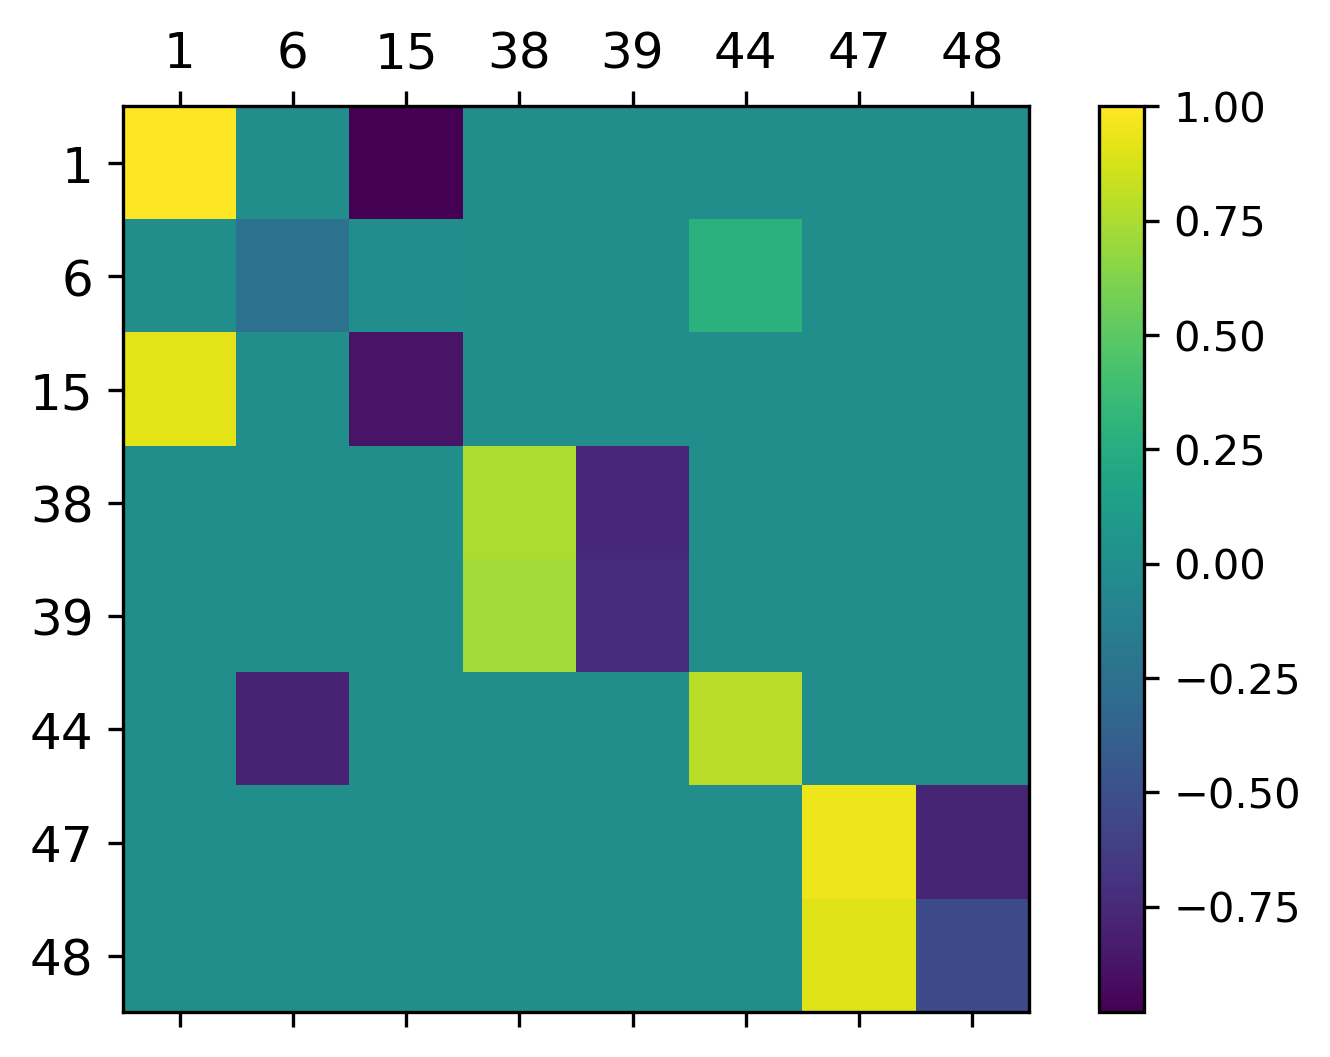

In [24]:

combined_preds = np.subtract(preds_b, preds_a)
# plt.matshow(co/mbined_preds)
# alpha = [6, 12, 26, 30, 38, 39, 43, 44]
alpha = [1, 6, 15, 38, 39, 44, 47, 48]
filtered = combined_preds[np.ix_(alpha, alpha)]
# filtered = combined_preds[np.ix_([1, 6, 15, 38, 39, 44, 47, 48],[1, 6, 15, 38, 39, 44, 47, 48])]
print(filtered)
filtered = filtered / np.amax(filtered)

def plot_author_graph(data, alpha):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest')
    fig.colorbar(cax)

    xaxis = np.arange(len(alpha))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(alpha, fontsize=12)
    ax.set_yticklabels(alpha, fontsize=12)
#     ax.set_xlabel('$Predicted$' + ' ' + '$Author$' + ' ' + '$A_{i}$', fontsize=16, labelpad=12)
#     ax.set_ylabel('$Actual$' + ' ' + '$Author$' + ' ' + '$A_{j}$', fontsize=16)
    ax.xaxis.set_label_position('top') 
    
    plt.show()

plot_author_graph(filtered, alpha)
    
# alpha = [6, 12, 26, 30, 38, 39, 43, 44]
# # alpha = [1, 6, 15, 38, 39, 44, 47, 48]
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(filtered, interpolation='nearest')
# fig.colorbar(cax)

# xaxis = np.arange(len(alpha))
# ax.set_xticks(xaxis)
# ax.set_yticks(xaxis)
# ax.set_xticklabels(alpha)
# ax.set_yticklabels(alpha)
# ax.set_xlabel('Predicted Author')
# ax.set_ylabel('Actual Author')

# plt.show()

In [20]:
df = pd.read_csv('21b.csv')
pred = df['actual_pred'].tolist()
true = df['author'].tolist()
print(precision_recall_fscore_support(true, pred, average='macro'))
print(accuracy_score(true, pred))

(0.8010436368762235, 0.7999393885107189, 0.7984077160093991, None)
0.8059125964010283
